<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/Boston_housing_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing packages
!pip install jaxopt
!pip install tinygp

In [2]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jaxopt
import tinygp
jax.config.update("jax_enable_x64", True)
import pandas as pd
from scipy import optimize

In [3]:
#reading csv file for Boston Housing Dataset
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['hou_all.csv']),\
                 names = ['CRIM','ZN','INDUS','CHAS','NOS','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])

Saving hou_all.csv to hou_all.csv


Maximum likelihood parameters:
{'log_amp': DeviceArray(17.29097137, dtype=float64), 'log_scale': DeviceArray(-8.52064811, dtype=float64), 'mean': DeviceArray(22., dtype=float64)}
506


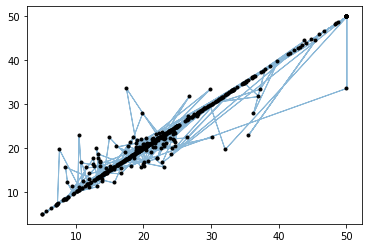

In [5]:
#Regression problem using Bayesian inference
RM = df['RM'].tolist()
MEDV = df['MEDV'].tolist()
X=np.array(RM)

#additive Gaussian noise
yerr = 0.01
y = np.array(MEDV)

#training model
def train_gp(build_gp_func):
    @jax.jit
    def loss(params):
        return -build_gp_func(params).log_probability(y)

    #hyperparameters
    params = {
        "log_amp": np.log(0.1),
        "log_scale": np.log(0.1),
        "mean": np.float64(22)
        }
    solver = jaxopt.ScipyMinimize(fun=loss)
    soln = solver.run(params)
    print("Maximum likelihood parameters:")
    print(soln.params)
    return build_gp_func(soln.params)

#building prior model
def build_gp(params):
    kernel = jnp.exp(params["log_amp"]) * tinygp.transforms.Linear(
        jnp.exp(-params["log_scale"]), tinygp.kernels.ExpSquared()
    )
    return tinygp.GaussianProcess(kernel, X, diag=yerr**2)

gp = train_gp(build_gp)

#Bayesian inference
gp_cond = gp.condition(y, X).gp

#mean and variance
mu, var = gp_cond.loc, gp_cond.variance

#plotting scatter diagram
plt.plot(y, mu, ".k")

#plotting variance
plt.fill_between(
    y, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)

In [ ]:
#Linear Regression problem using Bayesian inference (CRIM vs. MEDV)
CRIM = df['CRIM'].tolist()
ZN = df['ZN'].tolist()
Price = df['MEDV'].tolist()
X=np.vstack((CRIM,ZN)).T

#additive Gaussian noise
yerr = 0.01
y = np.vstack(Price).T

#hyperparameters
params = {
    "mean": np.float64(0.01),
    "log_diag": np.float64(0.01),
    "log_amp": np.log(0.1),
    "log_scale": np.log(0.1),
    "log_period": np.float64(0.0)
    }

#Kernel = Matern52
kernel = jnp.exp(params["log_amp"]) * tinygp.transforms.Linear(
        jnp.exp(-params["log_scale"]), tinygp.kernels.Matern52()
    )
gp = tinygp.GaussianProcess(kernel, X, diag=jnp.exp(params["log_diag"]), mean=params["mean"])

#loss function
@jax.jit
def loss(params):
    return gp.log_probability(y)

#minimizing loss function
solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(params)
print("Maximum likelihood parameters:")
print(soln.params)

gp_cond = gp.condition(y, X).gp
mu, var = gp_cond.loc, gp_cond.variance
print(mu)

TypeError: ignored